In [1]:
#import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from mapie.metrics import regression_coverage_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import explained_variance_score
from matplotlib.legend import _get_legend_handles_labels
from sklearn.model_selection import train_test_split

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # disable debugging logs from Tensorflow
import warnings
warnings.filterwarnings('ignore')
plt.rc('xtick',labelsize=19)
plt.rc('ytick',labelsize=19)
plt.rc('axes', labelsize=20, titlesize=16)
# To plot consistent and pretty figures
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rcParams['font.family'] = 'times new roman'
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['savefig.dpi'] = 120
def function(x):
    """One-dimensional x*sin(x) function."""
    return x * np.cos(x)

def data_het(
    funct, min_x, max_x, n_samples, noise
):
    """
    Generate 1D noisy data uniformly from the given function
    and standard deviation for the noise.
    """
    np.random.seed(59)
    X_train = np.linspace(min_x, max_x, n_samples)
    np.random.shuffle(X_train)
    X_test = np.linspace(min_x, max_x, n_samples * 10)
    y_train = (
        funct(X_train) +
        (np.random.normal(0, noise, len(X_train)) * X_train)
    )
    y_test = (
        funct(X_test) +
        (np.random.normal(0, noise, len(X_test)) * X_test)
    )
    y_mesh = funct(X_test)
    return (
        X_train.reshape(-1, 1), y_train, X_test.reshape(-1, 1), y_test, y_mesh
    )


def jackknife_plus(X,Y,Xtest,Ytest,alpha):
    n = X.shape[0]              
    ntest = Xtest.shape[0]         
    R = np.zeros(n)              
    y_pred=np.zeros((n,ntest))
    res=[]
    for i in np.arange(n):
        X_ = np.delete(X,i,0)
        Y_ = np.delete(Y,i)
        polyn_model.fit(X_, Y_)
        R[i] = np.abs(Y[i] - polyn_model.predict(X[i].reshape(1, -1)))
        y_pred[i]=polyn_model.predict(Xtest)
    PIs = np.zeros((ntest,2))    
    for itest in np.arange(ntest):
        q_lo = np.sort(y_pred[:,itest]-R)[::-1][(np.ceil((1-alpha)*(n+1))).astype(int)]
        q_hi = np.sort(y_pred[:,itest]+R)[(np.ceil((1-alpha)*(n+1))).astype(int)]
        PIs[itest] = np.array([q_lo,q_hi])
    coverage=round(regression_coverage_score(Ytest, PIs[:,0], PIs[:,1]),3)
    width=( PIs[:,1] - PIs[:,0]).mean().round(3)
    ypred = PIs.mean(axis=1)
    res.append([alpha,coverage,width,PIs])
    return res
def weighted_jackknife_plus(X,Y,Xtest,Ytest,alpha):
    n = X.shape[0]              
    ntest = Xtest.shape[0]          
    R = np.zeros(n)              
    y_pred=np.zeros((n,ntest))
    d=np.zeros((n,ntest))
    w=np.zeros((n,ntest))
    res=[]
    for i in np.arange(n):
        X_ = np.delete(X,i,0)
        Y_ = np.delete(Y,i)
        polyn_model.fit(X_, Y_)
        R[i] = np.abs(Y[i] - polyn_model.predict(X[i].reshape(1, -1)))
        y_pred[i]=polyn_model.predict(Xtest)
        d[i]=1/(cdist(X[i].reshape(1,-1),Xtest,'euclidean')) 

    PIs = np.zeros((ntest,2))    
   
    for itest in np.arange(ntest):
        w[:,itest] = d[:,itest]/d[:,itest].sum()
        q_lo = np.sort(y_pred[:,itest]-(w[:,itest]*R*n))[::-1][(np.ceil((1-alpha)*(n+1))).astype(int)]
        q_hi = np.sort(y_pred[:,itest]+(w[:,itest]*R*n))[(np.ceil((1-alpha)*(n+1))).astype(int)]
        PIs[itest] = np.array([q_lo,q_hi])

    coverage=round(regression_coverage_score(Ytest, PIs[:,0], PIs[:,1]),3)
    width=( PIs[:,1] - PIs[:,0]).mean().round(3)
    ypred = PIs.mean(axis=1)
    res.append([alpha,coverage,width,PIs])
    return res


def plot(
    X_train,
    y_train,
    X_test,
    y_test,
    y_pred,
    y_pred_low,
    y_pred_up,
    ax=None,
    title=None,
):
    ax.fill_between(X_test, y_pred_low, y_pred_up,color='lightgray', alpha=0.5, label="Prediction intervals")
    ax.scatter(X_train, y_train,color="red", s=10, alpha=0.3, label="Data point") 
#     ax.scatter(X_test, y_test,color="orange", s=1, alpha=0.3, label="Test data")
    if title is not None:
        ax.set_title(title,fontweight ='bold',fontsize=14)
        
  

In [2]:
X_train, y_train, X_test, y_test, y_mesh = data_het(function, 0, 5, 1000, 0.5)
#Scaling Transform
scaler = StandardScaler()

#PolynomialTransform
poly=PolynomialFeatures()

# Polynomial Ridge Regression model
reg=Ridge()
polyn_model = Pipeline([("scaler",scaler), ("poly", poly),("reg", reg)])

# Hyperparameter Optimization

#parameters of pipelines can be set using '__'separated parameter names:
param_grid=[
    {#Hyperparameter tuning in Polynomial Ridge Regression
    "poly__degree": [2,3,4,5],                #[2,3,4,5],
    "reg__alpha": np.logspace(-3,3,7),           #np.logspace(-3,3,7),
    },
]
models = [polyn_model] #polyn_model_quant, polyn_model, xgb_model, mlp_model
names=['polyn_model'] #'polyn_model_quant', 'polyn_model','xgb_model','mlp_model'
search_bestparams={}
for i,( name, model) in enumerate(zip(names, models)):
    search = GridSearchCV(model, param_grid[i], cv=5, scoring = 'explained_variance')
    search.fit(X_train, y_train)
    a=search.best_params_
    search_bestparams[name]=a

print("best parameters:",search_bestparams)

# ( base algorithm = Polynomial Ridge Regression)
poly = PolynomialFeatures(degree = search_bestparams['polyn_model']['poly__degree'])
reg = Ridge(alpha = search_bestparams['polyn_model']['reg__alpha'])
polyn_model = Pipeline([("scaler",scaler), ("poly", poly),("reg", reg)])

best parameters: {'polyn_model': {'poly__degree': 5, 'reg__alpha': 0.1}}


# Scenario 1: Heteroscedastic_noise 

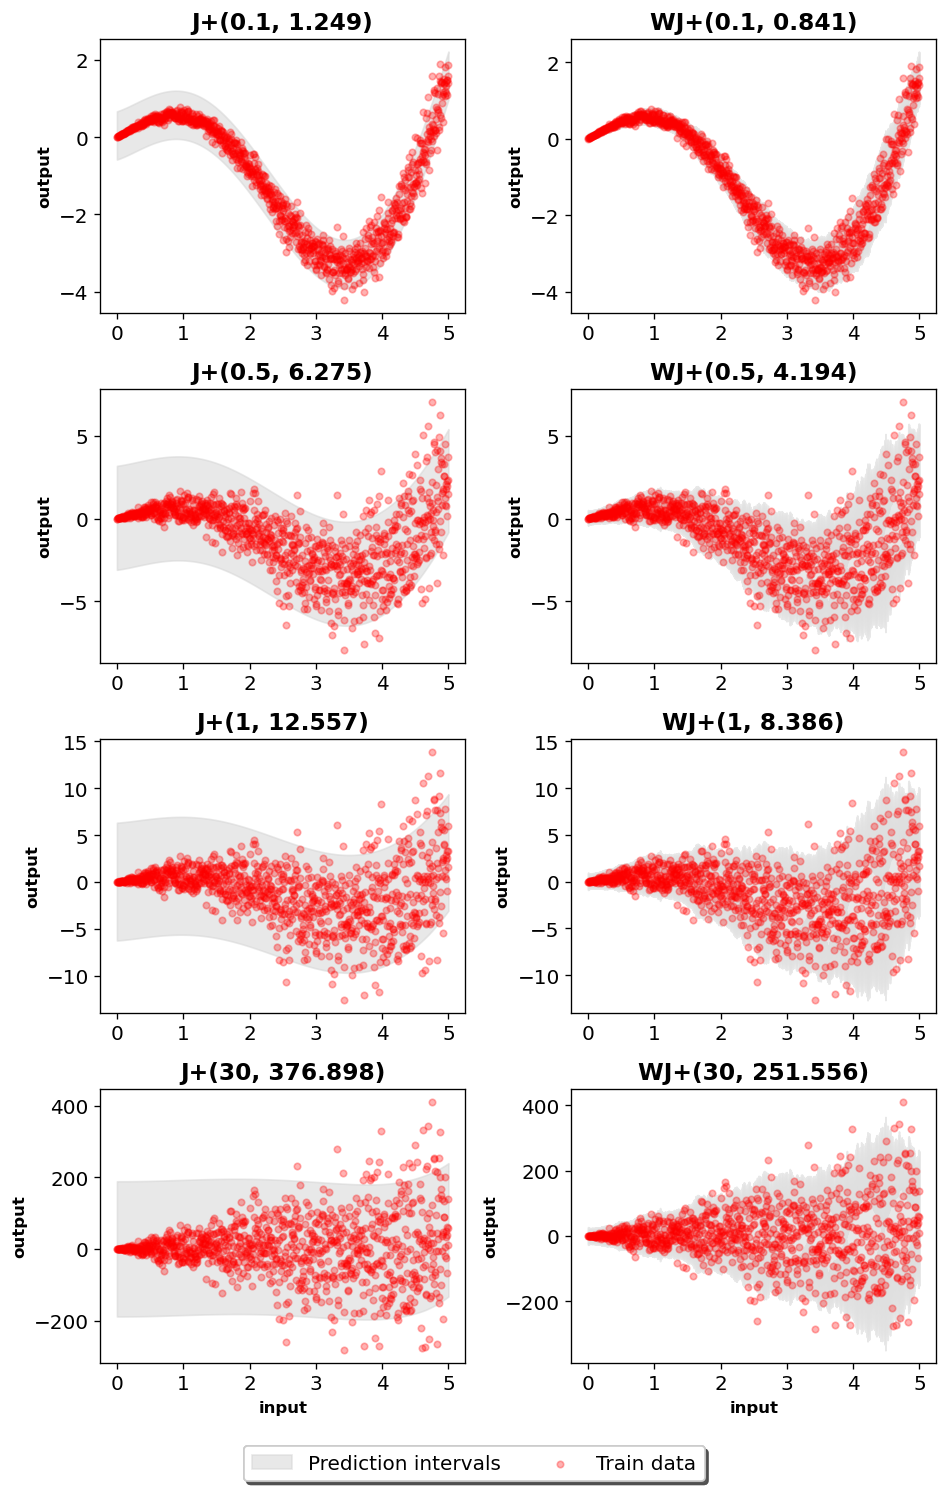

In [101]:
# [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,0.8,0.9,1]
noises = [0.1, 0.5,1,30]  # Define the noise values
num_noises = len(noises)
funcs = [jackknife_plus, weighted_jackknife_plus]
names = ['J+', 'WJ+']
results = {}

fig, axs = plt.subplots(num_noises, 2, figsize=(8, num_noises * 3))
for i, noise in enumerate(noises):
    X_train, y_train, X_test, y_test, y_mesh = data_het(function, 0, 5, 1000, noise)

    for name, func in zip(names, funcs):
        res = []
        result = func(X_train, y_train, X_test, y_test, alpha=0.05)
        res.append(result)
        results[name] = res

    coords = axs[i]
    for j, (name, coord) in enumerate(zip(names, coords)):
        plot(
            X_train.ravel(),
            y_train.ravel(),
            X_test.ravel(),
            y_test.ravel(),
            (results[name][0][0][3]).mean(axis=1).ravel(),
            results[name][0][0][3][:, 0].ravel(),
            results[name][0][0][3][:, 1].ravel(),
            ax=coord, #("(%s, %s)" % ( results[name][0][0][1],results[name][0][0][2] )) )
            title=name +  ("(%s, %s)" % ( noise,results[name][0][0][2] )) )
        coord.set_ylabel("output", fontweight='bold', fontsize=10) #(noise: {:.2f})".format(noise)
         

    lines, labels = fig.axes[0].get_legend_handles_labels()
    fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.002),#-0.02
               fancybox=True, shadow=True, ncol=5, fontsize=12)
fig.axes[6].set_xlabel("input", fontweight='bold', fontsize=10)
fig.axes[7].set_xlabel("input", fontweight='bold', fontsize=10)
plt.tight_layout()
plt.show()

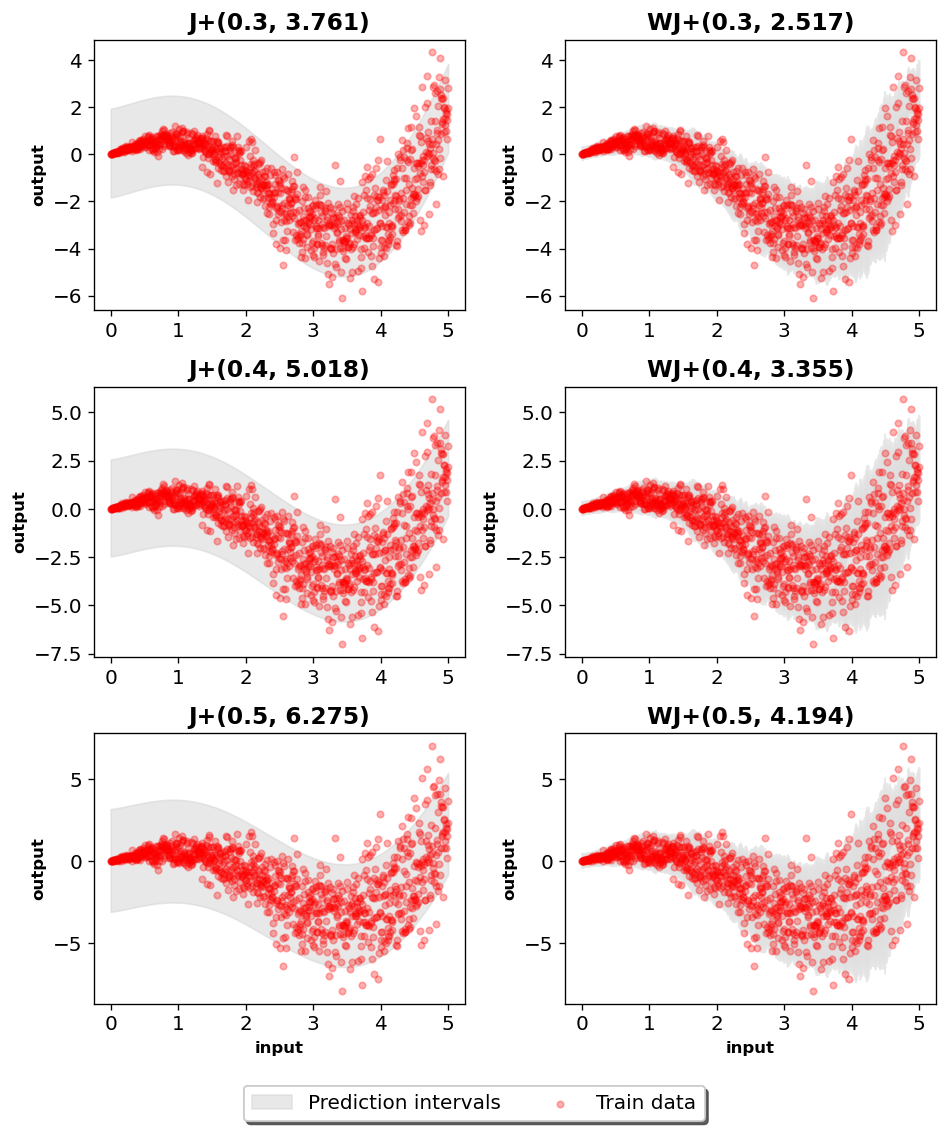

In [35]:
noises = [0.3,0.4, 0.5]  # Define the noise values
num_noises = len(noises)
funcs = [jackknife_plus, weighted_jackknife_plus]
names = ['J+', 'WJ+']
results = {}

fig, axs = plt.subplots(num_noises, 2, figsize=(8, num_noises * 3))
for i, noise in enumerate(noises):
    X_train, y_train, X_test, y_test, y_mesh = data_het(function, 0, 5, 1000, noise)

    for name, func in zip(names, funcs):
        res = []
        result = func(X_train, y_train, X_test, y_test, alpha=0.05)
        res.append(result)
        results[name] = res

    coords = axs[i]
    for j, (name, coord) in enumerate(zip(names, coords)):
        plot(
            X_train.ravel(),
            y_train.ravel(),
            X_test.ravel(),
            y_test.ravel(),
            (results[name][0][0][3]).mean(axis=1).ravel(),
            results[name][0][0][3][:, 0].ravel(),
            results[name][0][0][3][:, 1].ravel(),
            ax=coord, #("(%s, %s)" % ( results[name][0][0][1],results[name][0][0][2] )) )
            title=name +  ("(%s, %s)" % ( noise,results[name][0][0][2] )) )
        coord.set_ylabel("output", fontweight='bold', fontsize=10) #(noise: {:.2f})".format(noise)
         

    lines, labels = fig.axes[0].get_legend_handles_labels()
    fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.002),#-0.02
               fancybox=True, shadow=True, ncol=5, fontsize=12)
fig.axes[4].set_xlabel("input", fontweight='bold', fontsize=10)
fig.axes[5].set_xlabel("input", fontweight='bold', fontsize=10)
plt.tight_layout()
plt.show()

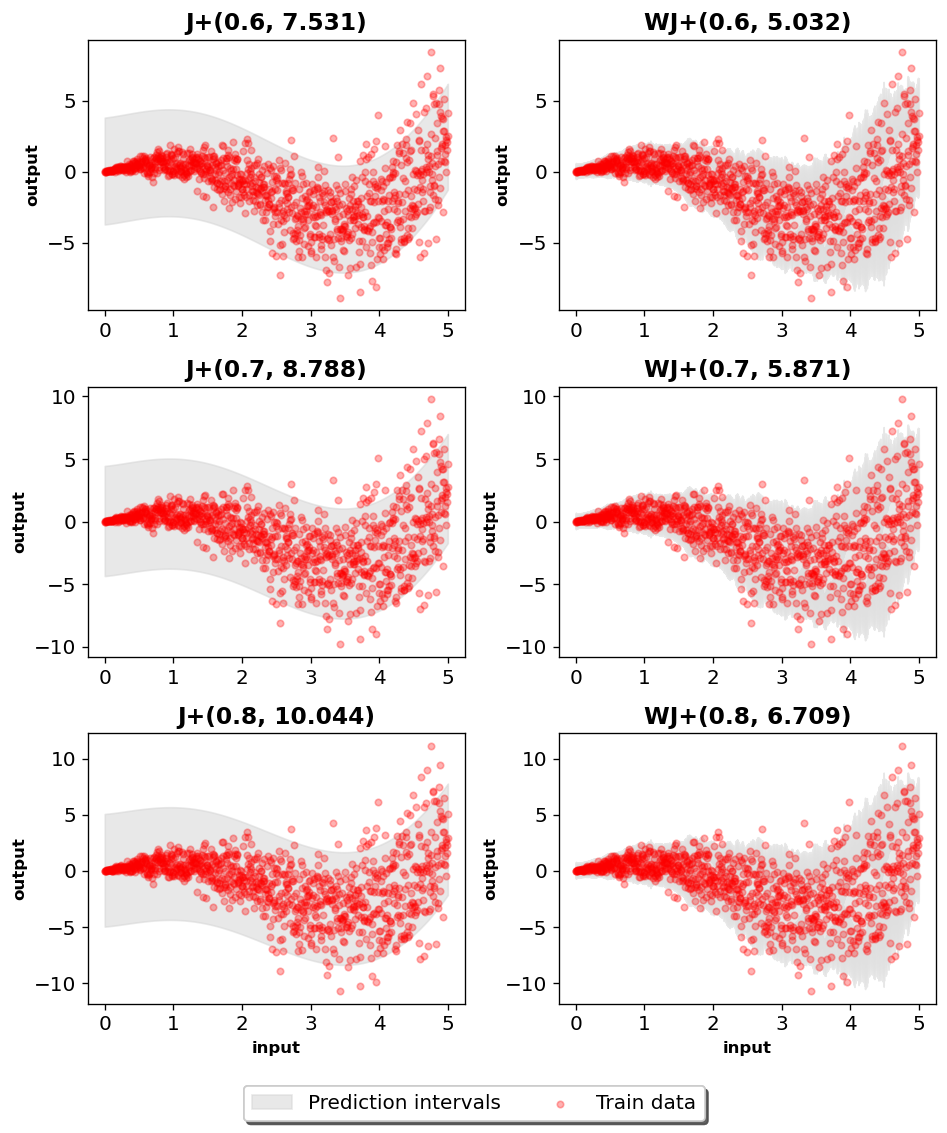

In [36]:
noises = [0.6, 0.7,0.8]  # Define the noise values
num_noises = len(noises)
funcs = [jackknife_plus, weighted_jackknife_plus]
names = ['J+', 'WJ+']
results = {}

fig, axs = plt.subplots(num_noises, 2, figsize=(8, num_noises * 3))
for i, noise in enumerate(noises):
    X_train, y_train, X_test, y_test, y_mesh = data_het(function, 0, 5, 1000, noise)

    for name, func in zip(names, funcs):
        res = []
        result = func(X_train, y_train, X_test, y_test, alpha=0.05)
        res.append(result)
        results[name] = res

    coords = axs[i]
    for j, (name, coord) in enumerate(zip(names, coords)):
        plot(
            X_train.ravel(),
            y_train.ravel(),
            X_test.ravel(),
            y_test.ravel(),
            (results[name][0][0][3]).mean(axis=1).ravel(),
            results[name][0][0][3][:, 0].ravel(),
            results[name][0][0][3][:, 1].ravel(),
            ax=coord, #("(%s, %s)" % ( results[name][0][0][1],results[name][0][0][2] )) )
            title=name +  ("(%s, %s)" % ( noise,results[name][0][0][2] )) )
        coord.set_ylabel("output", fontweight='bold', fontsize=10) #(noise: {:.2f})".format(noise)
         

    lines, labels = fig.axes[0].get_legend_handles_labels()
    fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.002),#-0.02
               fancybox=True, shadow=True, ncol=5, fontsize=12)
fig.axes[4].set_xlabel("input", fontweight='bold', fontsize=10)
fig.axes[5].set_xlabel("input", fontweight='bold', fontsize=10)
plt.tight_layout()
plt.show()

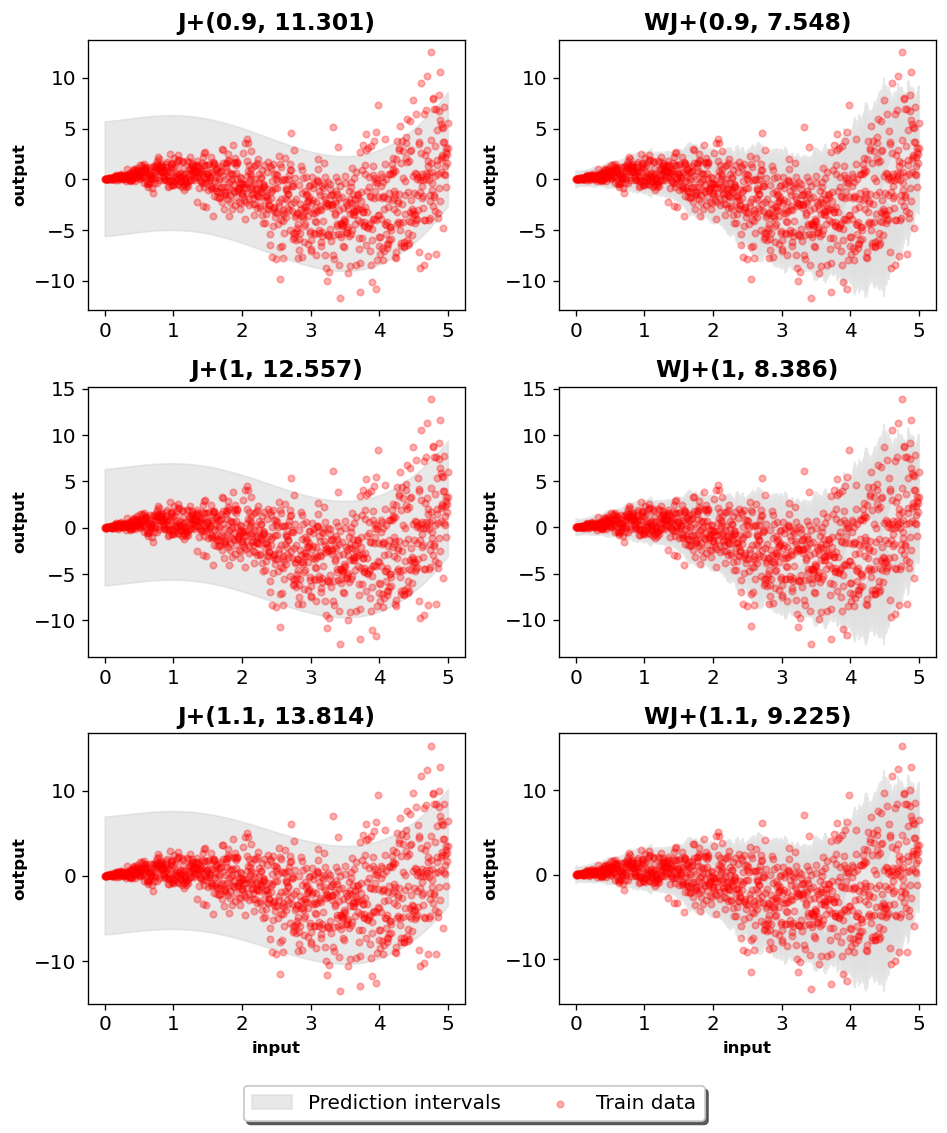

In [37]:
noises = [0.9, 1, 1.1]  # Define the noise values
num_noises = len(noises)
funcs = [jackknife_plus, weighted_jackknife_plus]
names = ['J+', 'WJ+']
results = {}

fig, axs = plt.subplots(num_noises, 2, figsize=(8, num_noises * 3))
for i, noise in enumerate(noises):
    X_train, y_train, X_test, y_test, y_mesh = data_het(function, 0, 5, 1000, noise)

    for name, func in zip(names, funcs):
        res = []
        result = func(X_train, y_train, X_test, y_test, alpha=0.05)
        res.append(result)
        results[name] = res

    coords = axs[i]
    for j, (name, coord) in enumerate(zip(names, coords)):
        plot(
            X_train.ravel(),
            y_train.ravel(),
            X_test.ravel(),
            y_test.ravel(),
            (results[name][0][0][3]).mean(axis=1).ravel(),
            results[name][0][0][3][:, 0].ravel(),
            results[name][0][0][3][:, 1].ravel(),
            ax=coord, #("(%s, %s)" % ( results[name][0][0][1],results[name][0][0][2] )) )
            title=name +  ("(%s, %s)" % ( noise,results[name][0][0][2] )) )
        coord.set_ylabel("output", fontweight='bold', fontsize=10) #(noise: {:.2f})".format(noise)
         

    lines, labels = fig.axes[0].get_legend_handles_labels()
    fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.002),#-0.02
               fancybox=True, shadow=True, ncol=5, fontsize=12)
fig.axes[4].set_xlabel("input", fontweight='bold', fontsize=10)
fig.axes[5].set_xlabel("input", fontweight='bold', fontsize=10)
plt.tight_layout()
plt.show()

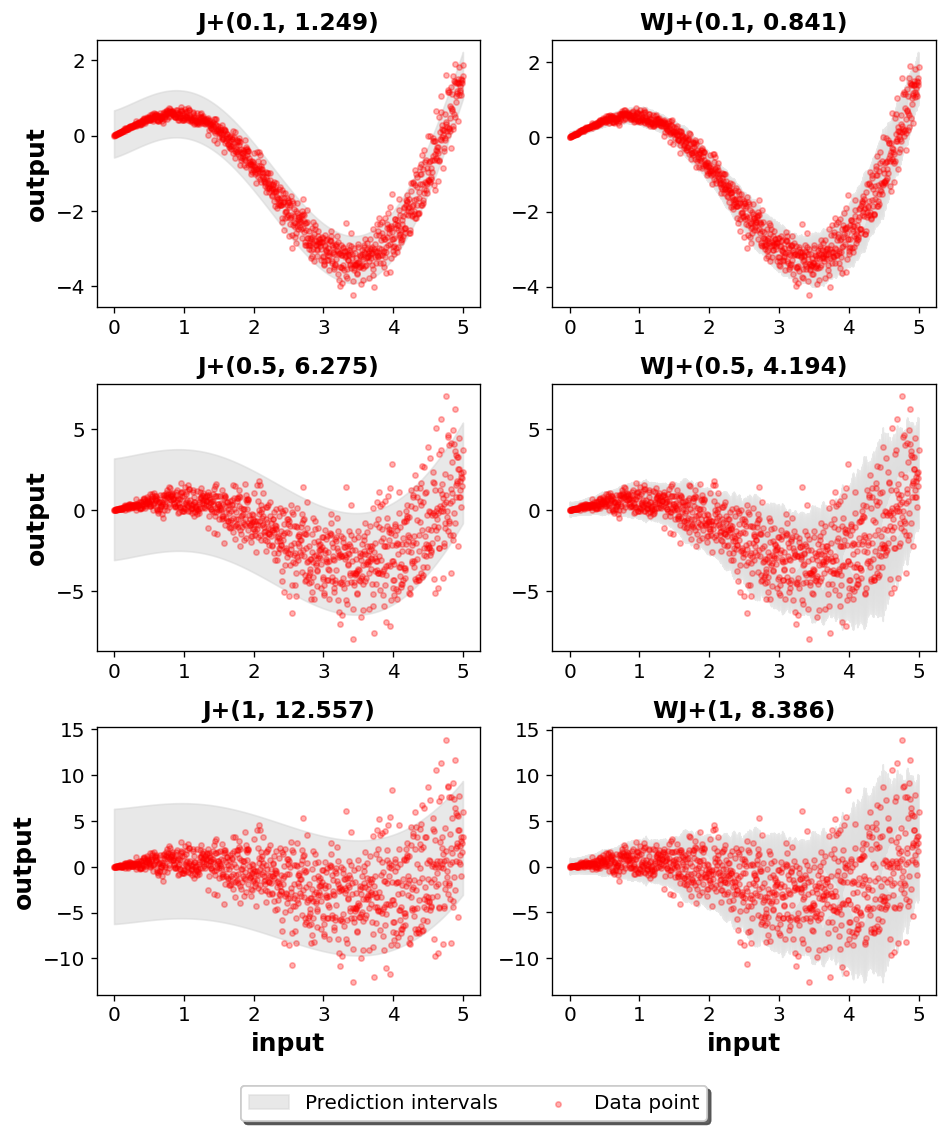

In [110]:
noises = [0.1, 0.5, 1]  # Define the noise values
num_noises = len(noises)
funcs = [jackknife_plus, weighted_jackknife_plus]
names = ['J+', 'WJ+']
results = {}

fig, axs = plt.subplots(num_noises, 2, figsize=(8, num_noises * 3))
for i, noise in enumerate(noises):
    X_train, y_train, X_test, y_test, y_mesh = data_het(function, 0, 5, 1000, noise)

    for name, func in zip(names, funcs):
        res = []
        result = func(X_train, y_train, X_test, y_test, alpha=0.05)
        res.append(result)
        results[name] = res

    coords = axs[i]
    for j, (name, coord) in enumerate(zip(names, coords)):
        plot(
            X_train.ravel(),
            y_train.ravel(),
            X_test.ravel(),
            y_test.ravel(),
            (results[name][0][0][3]).mean(axis=1).ravel(),
            results[name][0][0][3][:, 0].ravel(),
            results[name][0][0][3][:, 1].ravel(),
            ax=coord, #("(%s, %s)" % ( results[name][0][0][1],results[name][0][0][2] )) )
            title=name +  ("(%s, %s)" % ( noise,results[name][0][0][2] )) )
#         coord.set_ylabel("output", fontweight='bold', fontsize=20) #(noise: {:.2f})".format(noise)
         

    lines, labels = fig.axes[0].get_legend_handles_labels()
    fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.002),#-0.02
               fancybox=True, shadow=True, ncol=5, fontsize=12)
fig.axes[4].set_xlabel("input", fontweight='bold', fontsize=15)
fig.axes[5].set_xlabel("input", fontweight='bold', fontsize=15)
fig.axes[0].set_ylabel("output", fontweight='bold', fontsize=15)
fig.axes[2].set_ylabel("output", fontweight='bold', fontsize=15)
fig.axes[4].set_ylabel("output", fontweight='bold', fontsize=15)
plt.tight_layout()
plt.show()

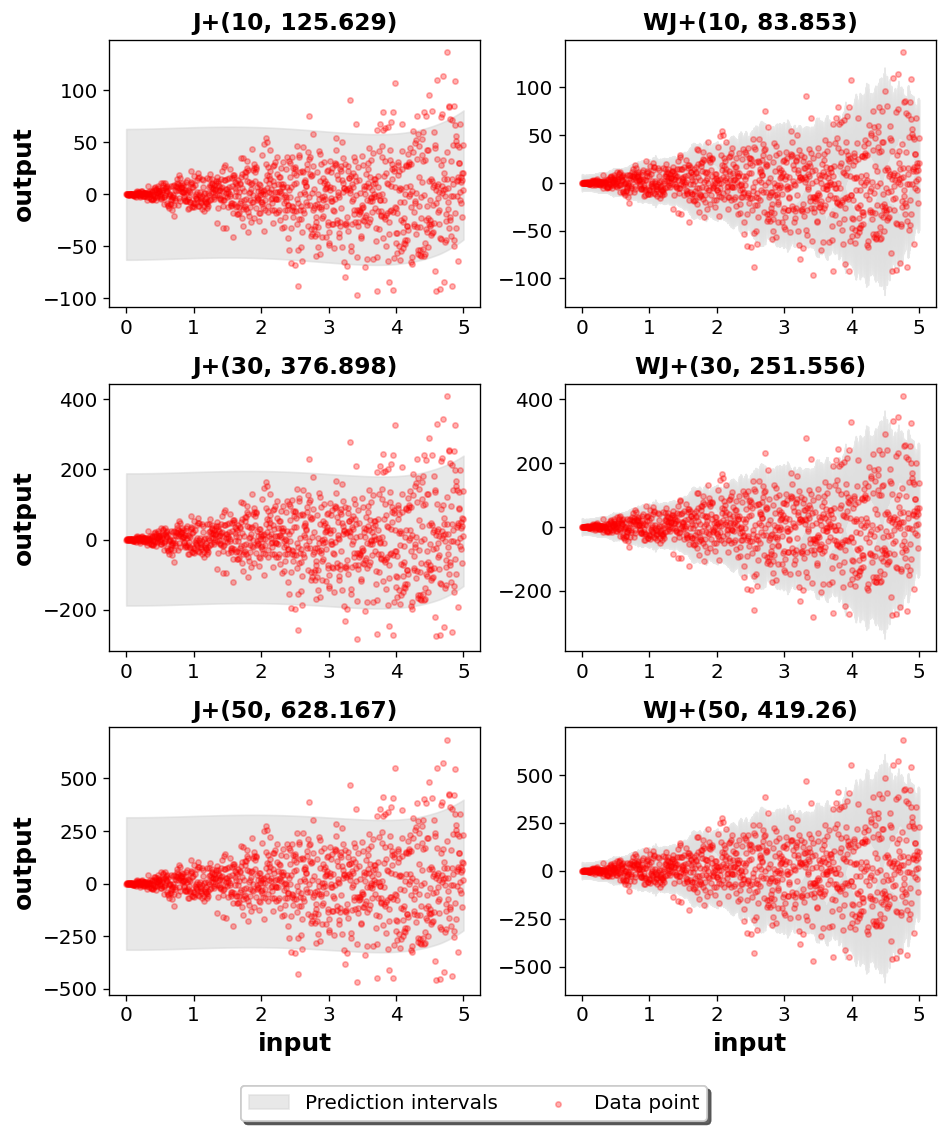

In [109]:
noises = [10, 30, 50]  # Define the noise values
num_noises = len(noises)
funcs = [jackknife_plus, weighted_jackknife_plus]
names = ['J+', 'WJ+']
results = {}

fig, axs = plt.subplots(num_noises, 2, figsize=(8, num_noises * 3))
for i, noise in enumerate(noises):
    X_train, y_train, X_test, y_test, y_mesh = data_het(function, 0, 5, 1000, noise)

    for name, func in zip(names, funcs):
        res = []
        result = func(X_train, y_train, X_test, y_test, alpha=0.05)
        res.append(result)
        results[name] = res

    coords = axs[i]
    for j, (name, coord) in enumerate(zip(names, coords)):
        plot(
            X_train.ravel(),
            y_train.ravel(),
            X_test.ravel(),
            y_test.ravel(),
            (results[name][0][0][3]).mean(axis=1).ravel(),
            results[name][0][0][3][:, 0].ravel(),
            results[name][0][0][3][:, 1].ravel(),
            ax=coord, #("(%s, %s)" % ( results[name][0][0][1],results[name][0][0][2] )) )
            title=name +  ("(%s, %s)" % ( noise,results[name][0][0][2] )) )
#         coord.set_ylabel("output", fontweight='bold', fontsize=20) #(noise: {:.2f})".format(noise)
         

    lines, labels = fig.axes[0].get_legend_handles_labels()
    fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.002),#-0.02
               fancybox=True, shadow=True, ncol=5, fontsize=12)
fig.axes[4].set_xlabel("input", fontweight='bold', fontsize=15)
fig.axes[5].set_xlabel("input", fontweight='bold', fontsize=15)
fig.axes[0].set_ylabel("output", fontweight='bold', fontsize=15)
fig.axes[2].set_ylabel("output", fontweight='bold', fontsize=15)
fig.axes[4].set_ylabel("output", fontweight='bold', fontsize=15)
plt.tight_layout()
plt.show()

In [11]:
results = {}
X_train, y_train, X_test, y_test, y_mesh = data_het(function, 0, 5, 1000,30) #change noise here each time
for name, func in zip(names, funcs):
    res = []
    result = func(X_train, y_train, X_test, y_test, alpha=0.05)
    res.append(result)
    results[name] = res
names=['J+','WJ+']
def het_cov1(y_test, results, names, bins):
    recap = {}
    for i in range(len(bins)-1):
        bin1, bin2 = bins[i], bins[i+1]
        name = f"[{bin1}, {bin2}]"
        recap[name] = []
        for strategy in names:
            indices = np.where((X_test >= bins[i]) * (X_test <= bins[i+1]))
            y_test_trunc = np.take(y_test, indices)
            y_low_ = np.take(results[strategy][0][0][3][:,0], indices)
            y_high_ = np.take(results[strategy][0][0][3][:,1], indices)
            score_coverage = regression_coverage_score(
                y_test_trunc[0], y_low_[0], y_high_[0]
            )
            recap[name].append(score_coverage)
    recap_df1 = pd.DataFrame(recap, index=names)
    print(recap_df1)
    return recap_df1


bins = [0, 1, 2, 3, 4, 5]
heteroscedastic_coverage = het_cov1(
    y_test, results, names, bins
)


names=['J+','WJ+']
def het_cov2(y_test, results, names, bins):
    recap = {}
    for i in range(len(bins)-1):
        bin1, bin2 = bins[i], bins[i+1]
        name = f"[{bin1}, {bin2}]"
        recap[name] = []
        for strategy in names:
            indices = np.where((X_test >= bins[i]) * (X_test <= bins[i+1]))
            y_test_trunc = np.take(y_test, indices)
            y_low_ = np.take(results[strategy][0][0][3][:,0], indices)
            y_high_ = np.take(results[strategy][0][0][3][:,1], indices)
            width=( y_high_[0] - y_low_[0]).mean().round(3)
            recap[name].append(width)
    recap_df2 = pd.DataFrame(recap, index=names)
    print(recap_df2)
    return recap_df2


bins = [0, 1, 2, 3, 4, 5]
heteroscedastic_coverage = het_cov2(
    y_test, results, names, bins
)



     [0, 1]  [1, 2]  [2, 3]  [3, 4]  [4, 5]
J+   1.0000  1.0000  0.9835  0.9315   0.817
WJ+  0.9435  0.8575  0.8735  0.8535   0.842
      [0, 1]   [1, 2]   [2, 3]   [3, 4]   [4, 5]
J+   377.304  377.305  377.305  377.062  375.512
WJ+   68.740  149.802  259.008  332.865  447.367


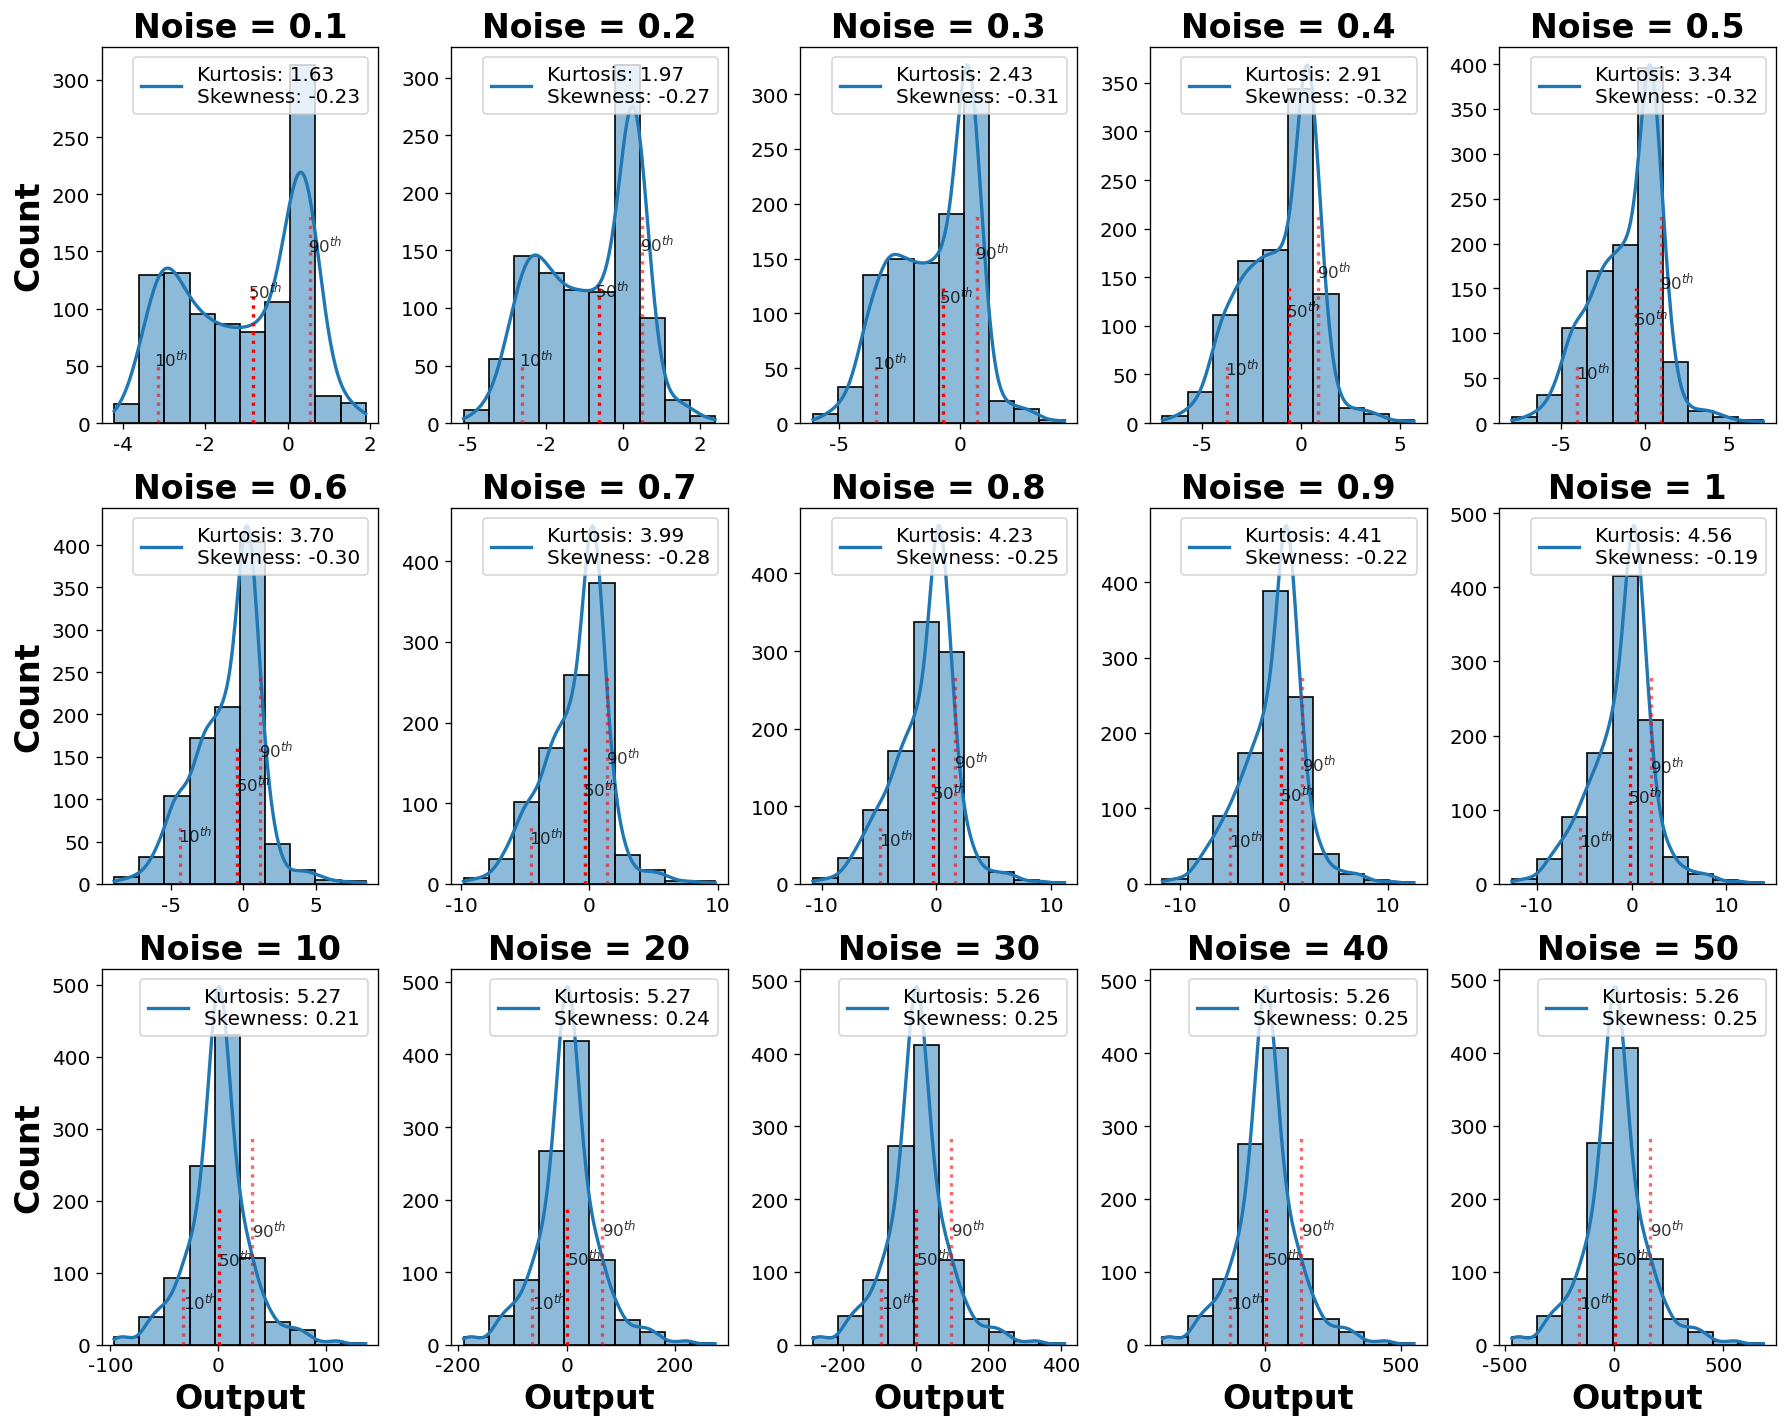

In [111]:
noise_levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1,10,20,30,40,50]

# Create the figure with subplots
fig, axs = plt.subplots(3,5, figsize=(15, 12))

# Flatten the axs array for easier indexing
axs = axs.flatten()

# Iterate over each noise level and create a histogram subplot
for i, noise in enumerate(noise_levels):
    # Generate the data for the given noise level
    X_train, y_train, X_test, y_test, y_mesh = data_het(function, 0, 5, 1000, noise)
    df_y = pd.DataFrame({'y': y_train})
    # Calculate kurtosis and skewness
    kurt = stats.kurtosis(y_train,fisher=False)
    skew = stats.skew(y_train)

    axs[i].set_title(f"Noise = {noise}",fontweight ='bold',fontsize=20)
    axs[i].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    sns.histplot(y_train, kde=True, bins=10, ax=axs[i])
    # Add the kurtosis and skewness values to the legend
    axs[i].legend([f"Kurtosis: {kurt:.2f}\nSkewness: {skew:.2f}"],fontsize=12)
    # Add quantile lines and labels
    quant_10, quant_50, quant_90 = df_y['y'].quantile(0.1), df_y['y'].quantile(0.5), df_y['y'].quantile(0.90)
    quants = [[quant_10, 0.6, 0.16], [quant_50, 1, 0.36], [quant_90, 0.6, 0.56]]
    for q in quants:
        axs[i].axvline(q[0], alpha=q[1], ymax=q[2], linestyle=":", c='r')
    axs[i].text(quant_10 - 0.1, 50, "$10^{th}$", size=10, alpha=0.8)
    axs[i].text(quant_50 - 0.13, 110, "$50^{th}$", size=10, alpha=0.8)
    axs[i].text(quant_90 - 0.05, 150, "$90^{th}$", size=10, alpha=0.8)

    
    
    
axs[10].set_xlabel("Output",fontweight ='bold',fontsize=20)
axs[11].set_xlabel("Output",fontweight ='bold',fontsize=20)
axs[12].set_xlabel("Output",fontweight ='bold',fontsize=20)
axs[13].set_xlabel("Output",fontweight ='bold',fontsize=20)
axs[14].set_xlabel("Output",fontweight ='bold',fontsize=20)
axs[0].set_ylabel("Count",fontweight ='bold',fontsize=20)
axs[5].set_ylabel("Count",fontweight ='bold',fontsize=20)
axs[10].set_ylabel("Count",fontweight ='bold',fontsize=20)
axs[1].set(ylabel='')
axs[2].set(ylabel='')
axs[3].set(ylabel='')
axs[4].set(ylabel='')
axs[6].set(ylabel='')
axs[7].set(ylabel='')
axs[8].set(ylabel='')
axs[9].set(ylabel='')
axs[11].set(ylabel='')
axs[12].set(ylabel='')
axs[13].set(ylabel='')
axs[14].set(ylabel='')
# Adjust the spacing between subplots
fig.tight_layout()

# Display the figure
plt.show()
